In [1]:
import numpy as np
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
import jax
from tensorflow_probability.substrates.jax import distributions as tfd
numpyro.set_host_device_count(4)

import matplotlib.pyplot as plt

Load pickled inputs:

In [2]:
import pickle

# Unpickle the variables
with open("/Users/christopher/git/ComputableAstronomicalDiaries/PythonExperiments/vars2.pkl", "rb") as f:
    loaded_variables = pickle.load(f)

# Access the variables
cubits = loaded_variables["cubits"]
times = loaded_variables["times"]
objects = loaded_variables["objects"]
references = loaded_variables["references"]
axes = loaded_variables["axes"]
months = loaded_variables["months"]
earliest_days = loaded_variables["earliest_days"]
latest_days = loaded_variables["latest_days"]
month_date_number = loaded_variables["month_date_number"]
date_number_index = loaded_variables["date_number_index"]
object_reference_axis_signed_distances = loaded_variables["object_reference_axis_signed_distances"]
time_range = loaded_variables["time_range"]
n_times = loaded_variables["n_times"]

In [3]:
object_reference_axis_signed_distances

Array([[[[[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]]],


        [[[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]]],


        [[[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]]],


        ...,


        [[[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],


In [4]:
from numpyro.ops.indexing import Vindex

In [4]:
def model():
	# length of a cubit
	cubit_length = numpyro.sample('cubit_length', dist.TruncatedNormal(2.0, 1.0, low=0.0))

	# observation variance
	distance_variance = numpyro.sample('distance_variance', dist.Gamma(0.5,0.5))

	# outlier distribution parameters
	outlier_mean = numpyro.sample('outlier_mean', dist.Normal(0,1))
	outlier_var = numpyro.sample('outlier_var', dist.Gamma(2.0,0.5))

	# time offsets for different observation times
	# TODO: Unclear if the .to_event(1) is correct. Maybe can be written with a plate?
	time_cat_means = numpyro.sample('time_cat_means', dist.Normal(jnp.zeros(n_times), jnp.ones(n_times) * 6.0).to_event(1))
	time_cat_vars = numpyro.sample('time_cat_vars', dist.Gamma(jnp.ones(n_times) * 0.5, jnp.ones(n_times) * 0.5).to_event(1))

	obs_plate = numpyro.plate('observations', cubits.shape[0])

	tau = numpyro.sample('tau', dist.Normal(time_cat_means[times], time_cat_vars[times]))

	# month_offset_a = numpyro.sample('month_offset_a', dist.Gamma(0.5,0.5))
	# month_offset_b = numpyro.sample('month_offset_b', dist.Gamma(0.5,0.5))
	# with numpyro.plate('month_offset_plate', month_date_number.shape[0]):
	# 	month_offsets = numpyro.sample('month_offsets', dist.BetaBinomial(month_offset_a, month_offset_b, 5))
	# 	month_offsets = month_offsets-3
	
	# month_offsets = jnp.zeros(month_date_number.shape[0], dtype=int)

	# with numpyro.plate('month_offset_plate', month_date_number.shape[0]):
	# 	month_offsets = numpyro.sample('month_offsets', dist.DiscreteUniform(-2,2))

	n_months = month_date_number.shape[0]
	# month_offsets = numpyro.sample(
	# 	'month_offsets',
	# 	dist.Categorical(probs=jnp.ones((n_months,5))),# .to_event(1),
	# 	# infer={"enumerate": "parallel"}
	# )

	l1 = numpyro.sample('l1', dist.Gamma(0.5,0.5))
	l2 = numpyro.sample('l2', dist.Gamma(0.5,0.5))
	skellam_probs = tfd.Skellam(l1,l2).prob(jnp.arange(-2,3,dtype=float))
	with numpyro.plate('month_offset_plate', n_months):
		month_offsets = numpyro.sample(
			'month_offsets',
			dist.Categorical(probs=skellam_probs),
			# infer={"enumerate": "parallel"}
		)
	month_offsets = month_offsets - 2
	
	# true displacements are the given observation times
	signed_distances = object_reference_axis_signed_distances[
		objects,
		references,
		axes,
		date_number_index[month_date_number[months] + month_offsets[months] + earliest_days]
	]
	true_distance = ((signed_distances[:,1]-signed_distances[:,0])/(time_range[1] - time_range[0])*(tau-time_range[1]))+signed_distances[:,1]

	# mixture model
	q = numpyro.sample('q', dist.Beta(1/2,1))
	cat = dist.Categorical(probs=jnp.array([1-q,q]))
	inlier_dist = dist.Normal(true_distance / cubit_length, distance_variance)
	outlier_dist = dist.Normal(outlier_mean, outlier_var)
	mix = dist.Mixture(cat, [inlier_dist, outlier_dist])

	with obs_plate:
		c = numpyro.sample('c', mix, obs=cubits)

		# record m for outlier identification
		log_probs = mix.component_log_probs(c)
		numpyro.deterministic('m', log_probs - jax.nn.logsumexp(log_probs, axis=-1, keepdims=True))

In [5]:
with numpyro.handlers.seed(rng_seed=0):
    trace = numpyro.handlers.trace(model).get_trace()
print(numpyro.util.format_shapes(trace))

           Trace Shapes:         
            Param Sites:         
           Sample Sites:         
       cubit_length dist      |  
                   value      |  
  distance_variance dist      |  
                   value      |  
       outlier_mean dist      |  
                   value      |  
        outlier_var dist      |  
                   value      |  
     time_cat_means dist      | 5
                   value      | 5
      time_cat_vars dist      | 5
                   value      | 5
      observations plate 5057 |  
                tau dist 5057 |  
                   value 5057 |  
                 l1 dist      |  
                   value      |  
                 l2 dist      |  
                   value      |  
month_offset_plate plate  608 |  
      month_offsets dist  608 |  
                   value  608 |  
                  q dist      |  
                   value      |  
                  c dist 5057 |  
                   value 5057 |  


In [6]:
kernel = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=1000, num_samples=4000, num_chains=4, progress_bar=True)
mcmc.run(jax.random.PRNGKey(1234))

/Users/christopher/git/ComputableAstronomicalDiaries/PythonExperiments/.venv/lib/python3.12/site-packages/jax/_src/linear_util.py:193: FutureWarning: Some algorithms will automatically enumerate the discrete latent site month_offsets of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  ans = self.f(*args, **dict(self.params, **kwargs))


ValueError: Missing a plate statement for batch dimension -1 at site 'tau'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.

In [7]:
kernel = numpyro.infer.DiscreteHMCGibbs(numpyro.infer.NUTS(model))
mcmc = numpyro.infer.MCMC(kernel, num_warmup=1000, num_samples=4000, num_chains=4, progress_bar=True)
mcmc.run(jax.random.PRNGKey(1234))

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [9]:
mcmc.get_samples()['cubit_length']

Array([0.0104347 , 0.01052696, 0.0105859 , ..., 2.3902428 , 2.405187  ,
       2.3922007 ], dtype=float32)

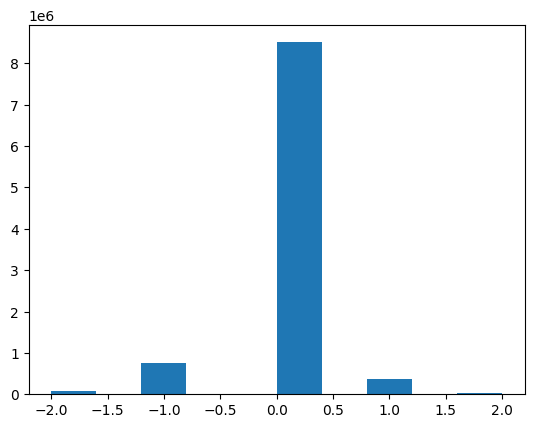

In [12]:
plt.hist((mcmc.get_samples()['month_offsets'] - 2).flatten())
plt.show()

In [11]:
with open('/Users/christopher/Downloads/month_offsets.pkl', 'wb') as f:
    pickle.dump(mcmc.get_samples()['month_offsets'] - 2, f)

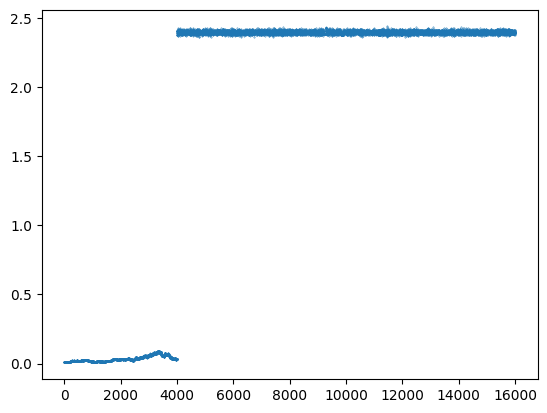

In [13]:
plt.scatter(jnp.arange(mcmc.num_samples * mcmc.num_chains), mcmc.get_samples()['cubit_length'], 0.1)
plt.show()

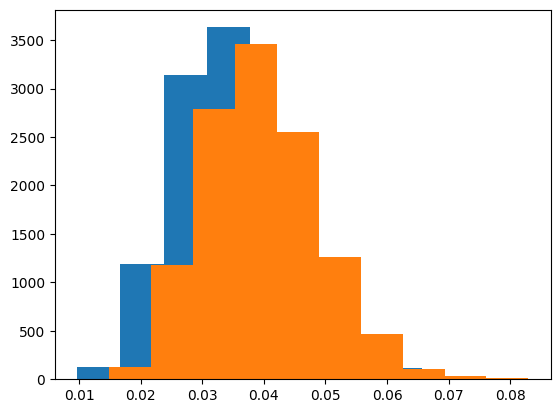

In [26]:
plt.hist(mcmc.get_samples()['l1'][4000:])
plt.hist(mcmc.get_samples()['l2'][4000:])
plt.show()

In [27]:
mcmc.get_samples()['l1'][4000:].mean()

Array(0.03436014, dtype=float32)

In [28]:
mcmc.get_samples()['l2'][4000:].mean()

Array(0.03962084, dtype=float32)

## Just use a custom Gibbs sampler?